### Import libriaries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

# Similarity
from sklearn.metrics.pairwise import cosine_similarity
from collections import OrderedDict

# supress warnings
import warnings
warnings.filterwarnings("ignore")

### Load Data

In [11]:
# load trainng and test data 
data_train = pd.read_csv('basket_data_by_date_train.csv')

data_test = pd.read_csv('basket_data_by_date_test.csv')

data_train.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost
0,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,1/12/2010 8:26,3.39,17850,20.34
1,536365,GLASS STAR FROSTED T-LIGHT HOLDER,6,1/12/2010 8:26,4.25,17850,25.50
2,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,1/12/2010 8:26,2.55,17850,15.30
3,536365,RED WOOLLY HOTTIE WHITE HEART.,6,1/12/2010 8:26,3.39,17850,20.34
4,536365,SET 7 BABUSHKA NESTING BOXES,2,1/12/2010 8:26,7.65,17850,15.30


In [12]:
data_test.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost
0,544398.0,JUMBO SHOPPER VINTAGE RED PAISLEY,1.0,18/02/2011 12:27,1.95,15311.0,1.95
1,544398.0,ZINC WILLIE WINKIE CANDLE STICK,4.0,18/02/2011 12:27,0.85,15311.0,3.40
2,544398.0,LOVE BUILDING BLOCK WORD,2.0,18/02/2011 12:27,5.95,15311.0,11.90
3,544398.0,HANGING FAIRY CAKE DECORATION,3.0,18/02/2011 12:27,2.10,15311.0,6.30
4,544398.0,RED HEART SHAPE LOVE BUCKET,1.0,18/02/2011 12:27,2.95,15311.0,2.95


### Analyse and Pre-process Data

check the missing value for training and test data

In [13]:
print('Shape of data:', data_train.shape)

Shape of data: (40000, 7)


In [25]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   BillNo      40000 non-null  int64  
 1   Itemname    40000 non-null  object 
 2   Quantity    40000 non-null  int64  
 3   Date        40000 non-null  object 
 4   Price       40000 non-null  float64
 5   CustomerID  40000 non-null  int64  
 6   cost        40000 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 2.1+ MB


In [14]:
data_train.isnull().sum()

BillNo        0
Itemname      0
Quantity      0
Date          0
Price         0
CustomerID    0
cost          0
dtype: int64

There is no missing value for training set

In [15]:
data_test.shape

(40000, 7)

In [16]:
data_test.isnull().sum()

BillNo        30000
Itemname      30000
Quantity      30000
Date          30000
Price         30000
CustomerID    30000
cost          30000
dtype: int64

In [17]:
# delete the null value
data_test = data_test[~data_test["BillNo"].isnull()]

In [18]:
data_test.isnull().sum()

BillNo        0
Itemname      0
Quantity      0
Date          0
Price         0
CustomerID    0
cost          0
dtype: int64

There is no null values in test set after data cleaning

Removes blank spaces 

In [44]:
data_train['Itemname'] = data_train['Itemname'].str.strip()
data_test['Itemname'] = data_test['Itemname'].str.strip()

Change the type of 'CustomerID', 'BillNo' to str, 'Quantity' to int

In [21]:
data_test['CustomerID'] = data_test['CustomerID'].astype(int).astype(str)
data_test['BillNo'] = data_test['BillNo'].astype(int).astype(str)
data_test['Quantity'] = data_test['Quantity'].astype(int)

In [24]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   BillNo      10000 non-null  object 
 1   Itemname    10000 non-null  object 
 2   Quantity    10000 non-null  int64  
 3   Date        10000 non-null  object 
 4   Price       10000 non-null  float64
 5   CustomerID  10000 non-null  object 
 6   cost        10000 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 625.0+ KB


In [26]:
data_train['CustomerID'] = data_train['CustomerID'].astype(str)
data_train['BillNo'] = data_train['BillNo'].astype(str)

In [27]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   BillNo      40000 non-null  object 
 1   Itemname    40000 non-null  object 
 2   Quantity    40000 non-null  int64  
 3   Date        40000 non-null  object 
 4   Price       40000 non-null  float64
 5   CustomerID  40000 non-null  object 
 6   cost        40000 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 2.1+ MB


check the vlidity of the data, make sure it is meaningful

In [42]:
data_train[(data_train['Quantity']<=0) | (data_train['Price']<=0) | (data_train['cost']<=0) ].head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost


In [43]:
data_test[(data_test['Quantity']<=0) | (data_test['Price']<=0) | (data_test['cost']<=0) ].head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost


All values of Quantity, Price and cost of transaction data are meaningful.

After data cleaning, there are 40000 observations in training set and 10000 observations in test set.

Show the unique number of customers and items

In [28]:
data_train["CustomerID"].nunique(), data_train["Itemname"].nunique()

(1391, 2523)

In the training set, 1391 different customers have purchased 2523 different items.

Use word clouds to show the frequency of items in the training dataset

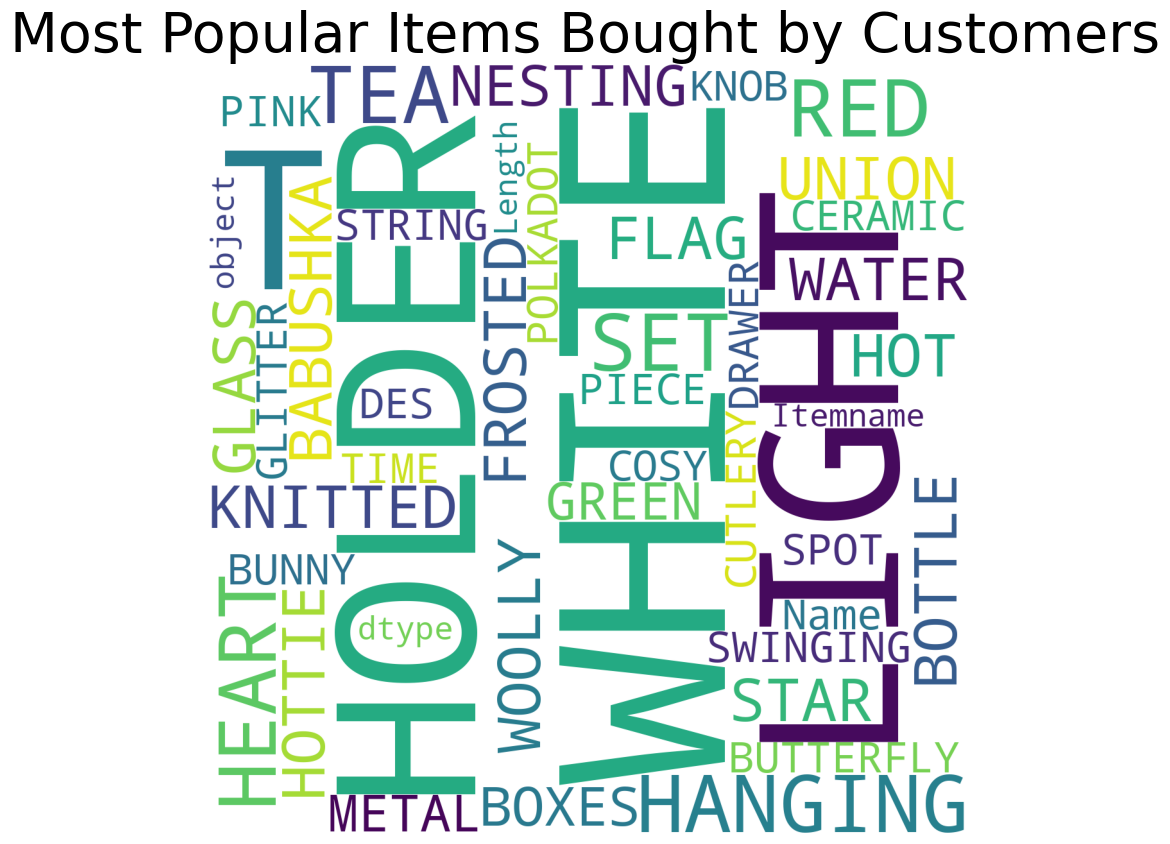

In [35]:
plt.rcParams['figure.figsize'] = (15, 10)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, min_font_size = 3).generate(str(data_train['Itemname']))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Popular Items Bought by Customers',fontsize = 40)
plt.show()

In [36]:
item_count = data_train.groupby(["Itemname"])["Quantity"].sum().reset_index().sort_values("Quantity", ascending = False)

item_count.reset_index(level = 0, inplace=True)


item_count.head(10)

,index,Itemname,Quantity
0,2436,WHITE HANGING HEART T-LIGHT HOLDER,1262
1,1183,JUMBO BAG RED RETROSPOT,1008
2,1289,LUNCH BAG RED RETROSPOT,1007
3,153,ASSORTED COLOUR BIRD ORNAMENT,840
4,1092,HEART OF WICKER LARGE,726
5,1998,SET OF 3 CAKE TINS PANTRY DESIGN,712
6,1422,NATURAL SLATE HEART CHALKBOARD,706
7,1189,JUMBO SHOPPER VINTAGE RED PAISLEY,667
8,1795,RED HANGING HEART T-LIGHT HOLDER,666
9,1291,LUNCH BAG SUKI DESIGN,661


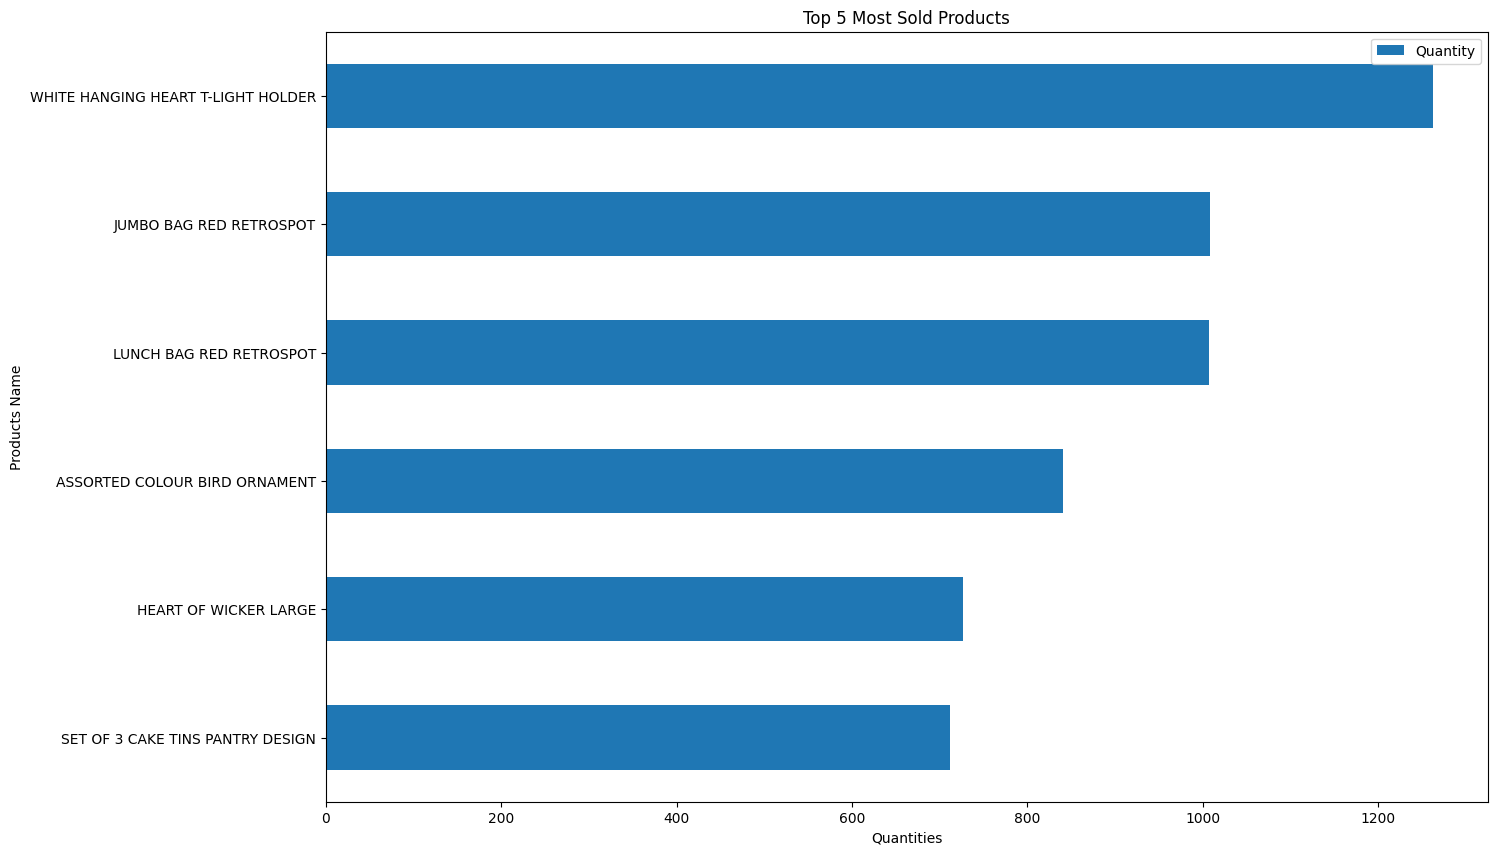

In [38]:
item_count_top5 = item_count.loc[0:5,["Itemname", "Quantity"]].sort_values("Quantity", ascending = True)


item_count_top5.plot(kind = "barh", x = "Itemname", align = "center")
plt.ylabel('Products Name')
plt.xlabel('Quantities')
plt.title('Top 5 Most Sold Products')
plt.show()

In [33]:
def plot_long_tail(item_names_column):
    # Count the frequency of each item
    item_frequency = item_names_column.value_counts()

    # Set threshold to 50% of total items bought by item rankings
    threshold = 0.5
    cumulative_freq_products = np.cumsum(item_frequency)
    popularity_threshold_item = len(cumulative_freq_products[cumulative_freq_products < item_frequency.sum() * threshold])
    popularity_threshold = item_frequency[popularity_threshold_item+1]

    fig, ax = plt.subplots(figsize=(10,5), dpi=100)

    # Plotting the count of each unique item by separating them with reference to popularity threshold
    for i in range(len(item_frequency)):
        if item_frequency[i] >= popularity_threshold:
            ax.bar(i, item_frequency[i], color="red")
        else:
            ax.bar(i, item_frequency[i], color="orange")

    # Setting labels and title
    ax.set_xlabel('Ranking of items by frequency of purchase')
    ax.set_ylabel('Frequency of purchase')
    ax.set_title(f'{(1-threshold)*100}% of items were bought less than {popularity_threshold} times present in long-tail')

    # Adding a vertical line to separate popular and unpopular items
    n_popular_items = sum(item_frequency >= popularity_threshold)
    ax.axvline(x=n_popular_items, color="black")
    
    plt.show()


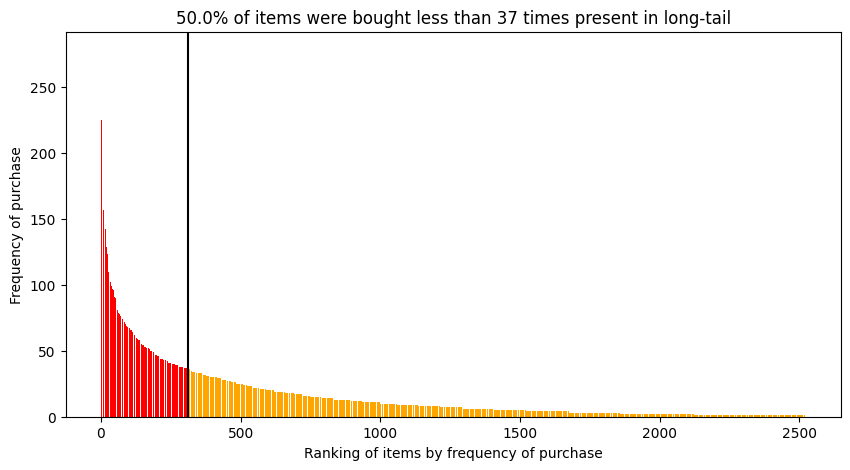

In [34]:
plot_long_tail(data_train["Itemname"])

From the chart above we see that half of the buyers purchased more than 2000 less popular items and a large number of items with low frequencies extending out into a long tail on the graph, indicating the existence of a strong long-tail problem.

In [39]:
data_summary = pd.merge( pd.DataFrame(data_train.CustomerID.value_counts()),
                 pd.DataFrame(data_train.groupby(['CustomerID'])['Itemname'].nunique()),
                 left_index = True, right_index = True).rename(columns = {'Itemname':'unique count', 'CustomerID':'total count'})

pd.DataFrame({"mean unique item count": data_summary['unique count'].mean(),
              "mean total item count": data_summary['count'].mean(),
              "mean Percentage of new items": (data_summary['unique count'].mean()/data_summary['count'].mean())*100,
              "mean Percentage of items repeated": (1-(data_summary['unique count'].mean()/data_summary['count'].mean()))*100},
              index=["For each user's entire transcation"])

,mean unique item count,mean total item count,mean Percentage of new items,mean Percentage of items repeated
For each user's entire transcation,24.654925,28.75629,85.7375,14.2625


From the table above it can be seen that the average percentage of users purchasing new items in each grocery transaction is 92, which suggests that they do not purchase the same items over and over again in each transaction. Therefore, it may not be meaningful to study the behavioural patterns of users' grocery transactions by date or transaction number. We can remove the columns where the data represents the date and transaction number and focus on the relationship between users and items.

In [4]:
data_train['value'] = 1
#creating the user-item interaction matrix
grocery_pivot = data_train.pivot_table(index='CustomerID',\
                                            columns='Itemname',\
                                            values='value')
grocery_pivot = grocery_pivot.fillna(0)

# Display first two rows of the groupby data frame
grocery_pivot.head()

Itemname,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,...,YULETIDE IMAGES S/6 PAPER BOXES,ZINC FINISH 15CM PLANTER POTS,ZINC HEART LATTICE 2 WALL PLANTER,ZINC HEART LATTICE CHARGER LARGE,ZINC HEART LATTICE CHARGER SMALL,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEART LATTICE TRAY OVAL,ZINC METAL HEART DECORATION,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
groceries_test = pd.DataFrame(data_test.\
                              groupby(['CustomerID'])\
                              ['Itemname'].unique())
groceries_test.head()

,Itemname
CustomerID,
12352.0,"[DELUXE SEWING KIT, VINTAGE CREAM DOG FOOD CON..."
12361.0,"[ROUND SNACK BOXES SET OF4 WOODLAND, ROUND SNA..."
12415.0,"[BREAD BIN DINER STYLE PINK, BREAD BIN DINER S..."
12417.0,"[RED RETROSPOT SUGAR JAM BOWL, BOX OF 6 ASSORT..."
12423.0,"[ROUND SNACK BOXES SET OF 4 FRUITS, ROUND SNAC..."


### Generate Recommendations from Training Data using Collaborative Filtering

In [9]:
user_similarity_cosine = cosine_similarity(grocery_pivot.fillna(0))

# Similarity values for the first user with other users
user_similarity_cosine[0]

array([1.        , 0.        , 0.06454972, ..., 0.05103104, 0.        ,
       0.08753762])

In [10]:
user_similarity_cosine.shape

(1391, 1391)

In [6]:
all_members = data_train['CustomerID'].unique().tolist()
all_members.sort()

In [7]:
cols = ["Member_number", "Items_Bought_Train", "Recommendations"]
recommendation_df = pd.DataFrame(columns = cols)

In [11]:
# Generate Recommendations
def generate_recommendations():
    """
    This function generates recommendations for all the Users in the training dataset
    
    Output: Prints the recommendations for every User in the training dataset
    """
    
    # Declare the data frame recommendation_df as global
    global recommendation_df
    
    # We will check the recommendations for all the users
    for i,user in enumerate(all_members):
        
        # Create a list of similarity scores for a user with other users
        similarity_score = list(enumerate(user_similarity_cosine[all_members.index(user)]))
        # Sort the similarities with similarities in descending order
        sorted_items = sorted(similarity_score, key = lambda x:x[1], reverse = True)
        
        # Create a list to store users based on similarity scores obtained before
        similar_users = []
        for similar_user in sorted_items[1:]:
            # fetch the index(first element of the tuple)
            user_index = similar_user[0]
            # Get the similarity value
            user_similarity = similar_user[1]
                
            # I am assuming a threshold of 0.5 to filter our best similar users
            # Very high similarities like above 0.9 is not viable because no two users buy the same products
            # throught the duration. 
            # Hence I am reducing the threshold to also obtain other products bought along with these products
            if (user_similarity > 0.50):
                # Obtain the transaction using the index
                similar_user = all_members[user_index]
                # Append to the list similar_transactions
                similar_users.append(similar_user)

        # Obtain the products purchased by the current user
        bought_products = data_train.loc[data_train.CustomerID == user, 
                                                  "Itemname"].copy()
        # Convert the pandas series object to a list
        bought_products = list(bought_products)
            
        # Obtain the products purchased by the users similar with our current user
        similar_items_bought = []
        # Checking for each user in similar users
        for u in similar_users:
            # Obtain the products
            items = data_train.loc[data_train.CustomerID == u, "Itemname"]
            # Append to the list
            similar_items_bought.append(list(items))
                
        # Obtain the items which are not purchased by the current user which were purchased in 
        # similar transactions with our current transaction
        untried_items = []
        for t in similar_items_bought:
            for item in t:
                # Obtain the untried products
                if item not in bought_products:
                    # Append to the list
                    untried_items.append(item)
                        
        # Import operator to get values in dictionary
        import operator
        # Create a dictionary
        frequency = {}
        # Now we are checking which item in untried products is bought and 
        # how many times they are bought by similar users
        for item in untried_items:
            # Add the item in dictionary if not present
            if item in frequency:
                frequency[item] += 1
            # Increment the count if present
            else:
                frequency[item] = 1
                    
        # Sort the dictionary items with items in descending order with items bought more frequently
        frequency = dict(sorted(frequency.items(), key=operator.itemgetter(1),reverse=True))
        
        # Obtain recommendations from the above dictionary
        recommended_items = []
        # Iterate through the dictionary and grab the top three most frequent items bought 
        # by similar users
        for j,key in enumerate(frequency.keys()):
            if j <= 2:
                recommended_items.append(key)
            
        # Print the recommendations
        # print("For Member -", user)
        # print("The top three recommended products are", recommended_items, "\n")
            
        # Add transaction, Items Bought by the user, respective recommendations into recommendation_df
        new_row = { 'Member_number': user, 'Items_Bought_Train': bought_products, 
                   'Recommendations': recommended_items}
        recommendation_df = pd.concat([recommendation_df, pd.DataFrame([new_row])], ignore_index=True)
        # recommendation_df = recommendation_df.append(pd.DataFrame([new_row], columns = recommendation_df.columns))
        
#start_time = time.time() 

# Generate Recommendations
generate_recommendations()

# end_time = time.time()
# m2_time = end_time - start_time
# print(f"Time taken: {m2_time:.4f} seconds")

In [12]:
recommendation_df.head()

,Member_number,Items_Bought_Train,Recommendations
0,12347,"[ALARM CLOCK BAKELIKE GREEN, CAMOUFLAGE EAR MU...",[]
1,12350,"[PINK/PURPLE RETRO RADIO, RETRO MOD TRAY]",[]
2,12352,"[WELCOME WOODEN BLOCK LETTERS, LOVE BUILDING ...",[]
3,12356,[RED RETROSPOT CAKE STAND],[CAKE STAND WHITE TWO TIER LACE]
4,12362,"[STRAWBERRY LUNCH BOX WITH CUTLERY, FELTCRAFT ...",[]


In [13]:
# function to return patterns and association rules
def apriori_p(data, s_min):
    # generate frequent itemsets
    frequent_itemsets = apriori(data, min_support=s_min, use_colnames=True)
    # Use association rules to generate recommendations
    rule = association_rules(frequent_itemsets, metric='lift', min_threshold=1)
    return rule.sort_values(by='confidence', ascending=False)

In [14]:
# Define a function to get top N new and repeated recommendations for a user
def get_recommendations_p(df, user_id, rules, N=3):
    # Get the items that the user has already rated
    user_items = df.loc[df['CustomerID'] == user_id, 'Itemname'].tolist()[0]

    # Filter the association rules to find those that involve at least one of the user's items
    relevant_rules = rules[rules['antecedents'].apply(lambda x: set(user_items).issuperset(x))]

    # Get the items that are recommended by the relevant rules
    recommended = relevant_rules['consequents'].apply(lambda x: list(x)[0]).tolist()

    # Total recommended items that include new and old (repeat)
    total_items = list(OrderedDict.fromkeys([item for item in recommended]))
    
    recommended_items = []
    count1 = 0
    for i in total_items:
        if i not in user_items and count1!=N:
            # getting top N recommended items in order of their rank
            recommended_items.append(i)
            count1 = count1 + 1
        if count1==N:
            break
        
    return recommended_items

def get_recommendations_c(df, user_id, ref, N=3):
    # list of all the Users in the training data
    all_members = ref['CustomerID'].unique().tolist()
    all_members.sort()
    
    # calculate similarity between users using cosine similarity
    user_sim_matrix = cosine_similarity(df)

    # get similarity scores between the given user and all other users
    user_sim_scores = user_sim_matrix[all_members.index(user_id)]

    # sort the similarity scores in descending order and get the indices of the top similar users
    similar_users_idx = np.argsort(user_sim_scores)[::-1]
    
    # creating a dataframe sorted based on Similarity_score with Member_number and items as other columns
    df2 = pd.DataFrame({'CustomerID': [all_members[i] for i in similar_users_idx],
                      'Similarity_score': np.sort(user_sim_scores)[::-1]})
    df_simi_user = df2[df2.Similarity_score.map(lambda x: x>0.2)]
    df_simi_user_data = pd.merge(df_simi_user, ref, on='CustomerID')

    # return the dataframe which is a cluster dataset where this user belongs
    return df_simi_user_data

In [15]:
groceries_train_data2 = pd.DataFrame(data_train.\
                                   groupby(['CustomerID'])\
                                   ['Itemname'].unique().map(tuple))\
                                   .reset_index()

In [ ]:
import random

# finding recomendation for a random user using hybrid method
user_id2 = random.choice(list(data_train.CustomerID))
df_simi_user_data = get_recommendations_c(grocery_pivot, user_id2,
                                                           data_train,N=3)

#creating the user-item interaction matrix
df_simi_user_data['value'] = 1
df_simi_user_data_as = df_simi_user_data.pivot_table(index='CustomerID',\
                                                           columns='Itemname',\
                                                           values='value')
df_simi_user_data_as = df_simi_user_data_as.fillna(0)
rules_2 = apriori_p(df_simi_user_data_as, 0.002)
df_simi_user_data_rec = get_recommendations_c(grocery_pivot, user_id2,
                                                           groceries_train_data2,N=3)

rec_items2  = get_recommendations_p(df_simi_user_data_rec,user_id2, rules_2, N=3)

print("For user", user_id2, ":")
print("\nTop 3 new recommendations are:")
history = data_train.loc[data_train['CustomerID'] == user_id2, 'Itemname']\
                               .values[0]
df_out = pd.DataFrame([[user_id2, history, rec_items2[0], rec_items2[1], rec_items2[2]],\
                    ], columns=["USER ID", "Transaction History (Train Dataset)", "1st Recommendation",\
                                '2st Recommendation', "3rd Recommendation"])
df_out

In [16]:
import random

# finding recomendation for a random user using hybrid method
user_id2 = random.choice(list(data_train.CustomerID))
df_simi_user_data = get_recommendations_c(grocery_pivot, user_id2,
                                                           data_train,N=3)

In [17]:
df_simi_user_data['value'] = 1
df_simi_user_data_as = df_simi_user_data.pivot_table(index='CustomerID',\
                                                           columns='Itemname',\
                                                           values='value')

In [18]:
df_simi_user_data_as = df_simi_user_data_as.fillna(0)
rules_2 = apriori_p(df_simi_user_data_as, 0.002)

: 

: 

In [45]:
def get_encoder_matrix(dataset: pd.DataFrame) -> pd.DataFrame:
    """
    Get the TransactionEncoder matrix to be used for mining frequent itemset
    
    Parameters:
    dataset : pd.DataFrame
            A DataFrame containing columns of "userID", "itemID", and "date"

    Returns:
        pd.DataFrame
            A DataFrame where each row represents a transaction and each column represents an item.
            If the item was bought, the corresponding cell is set to True, otherwise False.
    """
    
    # getting list of items for each transaction
    daily_transactions = (dataset
                          .groupby(by=['CustomerID'])['Itemname']
                          .agg(lambda x: list(x)))
    
    # Transform transaction data into a one-hot encoded format
    trans_encoder = TransactionEncoder() # Instantiate the encoder
    trans_encoder_matrix = trans_encoder.fit(daily_transactions).transform(daily_transactions)
    trans_encoder_matrix = pd.DataFrame(trans_encoder_matrix, columns=trans_encoder.columns_)
    
    return trans_encoder_matrix    

In [47]:
# generating the encoder matrix
trans_encoder_matrix = get_encoder_matrix(data_train)

# viewing the transcation encoder matrix
trans_encoder_matrix

,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,...,YULETIDE IMAGES S/6 PAPER BOXES,ZINC FINISH 15CM PLANTER POTS,ZINC HEART LATTICE 2 WALL PLANTER,ZINC HEART LATTICE CHARGER LARGE,ZINC HEART LATTICE CHARGER SMALL,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEART LATTICE TRAY OVAL,ZINC METAL HEART DECORATION,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1386,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1387,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1388,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1389,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [48]:
def get_frequent_itemset(data: pd.DataFrame, 
                          algorithm: str="fp-growth",
                          min_support: float=0.0006) -> pd.DataFrame:
    """
    Get the the frequent itemsets 
    
    Parameters:
    data : pd.DataFrame
            A DataFrame containing columns of "userID", "itemID", and "date"

    algorithm: str
            A string specifying the algorithm used (e.g. fp-growth, apriori)

    min_support: float
            A flaot number specifying the support threshold for mining frequent itemsets

    Returns:
        pd.DataFrame
            A DataFrame containing the frequent itemsets and the corresponding support
    """

    # Mining the frequent itemsets using fp-growth algorithm
    
    if algorithm == "fp-growth":
        rule_items = fpgrowth(get_encoder_matrix(data), 
                               min_support=min_support, 
                               use_colnames=True)
    # Mining the frequent itemsets using apriori algorithm
    
    else:
        rule_items = apriori(get_encoder_matrix(data), 
                               min_support=min_support, 
                               use_colnames=True)
    
    return rule_items

In [49]:
# importing library to evaluate execution 
import time

# getting runtime for FP-growth algorithm
start_time = time.time()
freq_items = get_frequent_itemset(data_train, 
                    algorithm="fp-growth",
                    min_support=0.0006)
fp_growth_time = time.time() - start_time




In [ ]:
# getting runtime for Apriori algorithm
start_time = time.time()
freq_items = get_frequent_itemset(data_train, 
                    algorithm="apriori",
                    min_support=0.0006)
apriori_time = time.time() - start_time

# printing execution times
print('Execution time for fp-growth algorithm : ', fp_growth_time)
print('Execution time for apriori algorithm : ', apriori_time)

plt.figure(figsize=(5,4))
sns.barplot(x=["FP-Growth", "Apriori"],
            y=[fp_growth_time, apriori_time])

# adding labels to axes
plt.xlabel("Pattern mining algorithm")
plt.ylabel("Runtime (seconds)")
plt.title("Runtime Comparision for Pattern Mining Algorithms")